In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
#mimiciv_dir = '/data/vision/polina/projects/chestxray/data_mimic_iv/0.4/'
mimiciv_dir = 'data'

## Part I: read data

In [19]:
df_event = pd.read_csv(f'{mimiciv_dir}/diagnoses_icd.csv', low_memory=False)
df_event[:10]

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9
3,15734973,20475282,1,64891,9
4,15734973,20475282,4,66481,9
5,11442057,21518990,1,65971,9
6,11442057,21518990,2,64231,9
7,11442057,21518990,6,V270,9
8,11442057,21518990,3,64511,9
9,11442057,21518990,5,65961,9


In [20]:
df_code = pd.read_csv(f'{mimiciv_dir}/d_icd_diagnoses.csv', low_memory=False)
df_code[:10]

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A
5,0022,9,Paratyphoid fever B
6,0023,9,Paratyphoid fever C
7,0029,9,"Paratyphoid fever, unspecified"
8,0030,9,Salmonella gastroenteritis
9,0031,9,Salmonella septicemia


In [21]:
#merge tables:
df_sub = pd.merge(df_event, df_code, on = ['icd_code','icd_version'], how='left')

#convert to lower case:
df_sub['long_title'] = df_sub['long_title'].str.lower()

df_sub = df_sub.dropna(subset=['icd_code','icd_version','hadm_id','subject_id','long_title'], how='any')

df_sub.head(5)

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,15734973,20475282,3,2825,9,sickle-cell trait
1,15734973,20475282,2,V0251,9,carrier or suspected carrier of group b strept...
2,15734973,20475282,5,V270,9,"outcome of delivery, single liveborn"
3,15734973,20475282,1,64891,9,other current conditions classifiable elsewher...
4,15734973,20475282,4,66481,9,"other specified trauma to perineum and vulva, ..."


## Part II: subsetting criteria

In [22]:
#Filter to heart failure: 
#Filter 1: long title contains "heart failure" AND long title doesnt contain without heart failure
# this paper: https://academic.oup.com/aje/article/183/5/462/2462157?login=true used almost all of these for ADHF
df_f1 = df_sub[df_sub['long_title'].str.contains('heart failure')]
df_f1 = df_f1[~df_f1['long_title'].str.contains('without heart failure')]
df_f1.head(5)

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
1161,16477997,25359811,2,42823,9,acute on chronic systolic heart failure
1164,16477997,25359811,10,4280,9,"congestive heart failure, unspecified"
1218,14959277,28740655,2,42822,9,chronic systolic heart failure
1223,14959277,28740655,4,4280,9,"congestive heart failure, unspecified"
1392,14559749,26693268,14,42822,9,chronic systolic heart failure


In [23]:
df_f1_hadm = df_f1[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
print(np.shape(df_f1_hadm)[0])
n1 = np.shape(df_f1_hadm)[0]
df_f1_hadm.head(5)

64686


,subject_id,hadm_id,long_title,icd_code,icd_version
1161,16477997,25359811,acute on chronic systolic heart failure,42823,9
1218,14959277,28740655,chronic systolic heart failure,42822,9
1392,14559749,26693268,chronic systolic heart failure,42822,9
1435,18894258,28336555,"congestive heart failure, unspecified",4280,9
1653,14974219,20480369,chronic systolic heart failure,42822,9


In [24]:
# Filter 2: Filter 1 + exclude "XX disease with heart failure" format (only keep HF as main target in title)
df_f2 = df_f1[~df_f1['long_title'].str.contains('disease')]
df_f2_hadm = df_f2[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
print(np.shape(df_f2_hadm)[0])
hf2_icd = df_f2[['long_title', 'icd_code','icd_version']].drop_duplicates(subset=['icd_code']) #.sort_values('icd_code')
hf2_icd
n2 = np.shape(df_f2_hadm)[0]

64566


In [25]:
# (not used) Filter 3: Filter 1+2+ only acute on chronic [Very narrow]
df_f3 = df_f2[df_f2['long_title'].str.contains('acute on chronic')]
df_f3_hadm = df_f3[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
print(np.shape(df_f3_hadm)[0])

20330


In [26]:
# (not used) Filter 4: Filter 1+2+ unspecified
df_f4 = df_f2[df_f2['long_title'].str.contains('unspecified')]
df_f4_hadm = df_f4[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
print(np.shape(df_f4_hadm)[0])

42018


In [27]:
# Filter 5: Filter 1+2+ Use I50+ and 428+
# source: https://icd.codes/icd10cm/I503 "The ICD code I50 is used to code Acute decompensated heart failure"
df_f5 = df_f2[df_f2['icd_code'].str.contains('428') | df_f2['icd_code'].str.contains('I50')]
df_f5_hadm = df_f5[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
n5=(np.shape(df_f5_hadm)[0])
n5

64409

In [29]:
# Filter 6: Filter 1+2+5+ exclude acute only, exclude chronic only, keep acute on chronic or specified
# source: NA_CARE_Prov_ICD_10_CM_Documentation_and_Coding_Best_Practices_Heart_Failure_v3_ENG_2019 pdf
df_f6 = df_f5[~df_f5['long_title'].str.contains('acute')  | df_f5['long_title'].str.contains('acute on chronic') ]
df_f6 = df_f6[~df_f6['long_title'].str.contains('chronic')  | df_f6['long_title'].str.contains('acute on chronic') ]
df_f6_hadm = df_f6[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
n6 = (np.shape(df_f6_hadm)[0])
n6

51330

In [31]:
# Filter 7: Filter 1+2+5+6 exclude end stage
# It is important to distinguish between AdHF and end-stage HF
# source https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6963179/
df_f7 = df_f6[~df_f6['long_title'].str.contains('end stage')]
df_f7_hadm = df_f7[['subject_id','hadm_id','long_title', 'icd_code','icd_version']].drop_duplicates(subset=['hadm_id'])
n7 = (np.shape(df_f7_hadm)[0])
n7

51303

In [14]:
df_f7_hadm

,subject_id,hadm_id,long_title,icd_code,icd_version
1161,16477997,25359811,acute on chronic systolic heart failure,42823,9
1223,14959277,28740655,"congestive heart failure, unspecified",4280,9
1435,18894258,28336555,"congestive heart failure, unspecified",4280,9
1662,14974219,20480369,"congestive heart failure, unspecified",4280,9
1677,12849817,27891695,"congestive heart failure, unspecified",4280,9
1787,11508679,25781770,"congestive heart failure, unspecified",4280,9
1840,18151621,25727457,"congestive heart failure, unspecified",4280,9
2520,12711129,26466704,acute on chronic diastolic heart failure,42833,9
2622,18982551,28769191,"congestive heart failure, unspecified",4280,9
2716,13427502,20353250,"congestive heart failure, unspecified",4280,9


In [17]:
#ICD counts for version 9 and 10: 
#df_f1['icd_version'].value_counts()

## Part III: Breakdown / analysis / visuals 

In [32]:
#list of icd_code associated with patients passing above filter 1
hf_icd = df_f7[['long_title', 'icd_code','icd_version','seq_num']].drop_duplicates(subset=['icd_code']) #.sort_values('icd_code')
hf_icd.to_csv('dhf_icd.csv')
hf_icd

,long_title,icd_code,icd_version,seq_num
1161,acute on chronic systolic heart failure,42823,9,2
1164,"congestive heart failure, unspecified",4280,9,10
2520,acute on chronic diastolic heart failure,42833,9,4
4216,acute on chronic combined systolic and diastol...,42843,9,2
4514,"combined systolic and diastolic heart failure,...",42840,9,6
6145,"diastolic heart failure, unspecified",42830,9,2
7156,"systolic heart failure, unspecified",42820,9,6
25859,"heart failure, unspecified",4289,9,1
51436,left heart failure,4281,9,3
2996323,unspecified diastolic (congestive) heart failure,I5030,10,2


In [96]:
df_icd_size = pd.DataFrame({'count' : df_f7.groupby(['icd_code']).size()}).reset_index()
df_icd_summary = pd.merge(hf_icd, df_icd_size, on = ['icd_code'], how='left').sort_values(['icd_version','count'],ascending=[True,False])
df_icd_summary

,long_title,icd_code,icd_version,seq_num,count
1,"congestive heart failure, unspecified",4280,9,10,36891
2,acute on chronic diastolic heart failure,42833,9,4,5533
0,acute on chronic systolic heart failure,42823,9,2,4508
5,"diastolic heart failure, unspecified",42830,9,2,1408
3,acute on chronic combined systolic and diastol...,42843,9,2,1232
6,"systolic heart failure, unspecified",42820,9,6,749
7,"heart failure, unspecified",4289,9,1,125
4,"combined systolic and diastolic heart failure,...",42840,9,6,120
8,left heart failure,4281,9,3,42
11,acute on chronic diastolic (congestive) heart ...,I5033,10,7,4950


In [58]:
df_icd_summary.to_csv('df_icd_summary.csv',index=False)

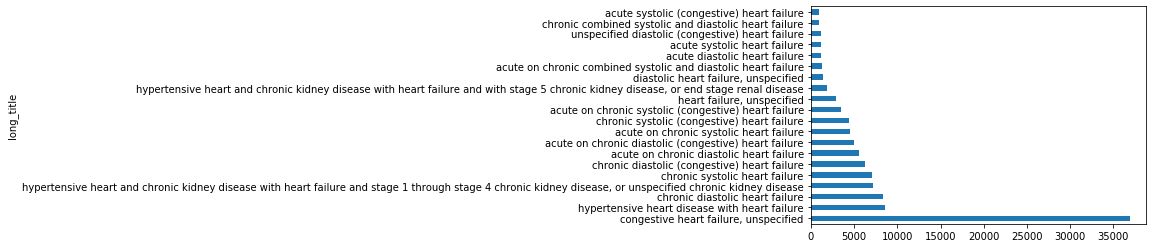

In [35]:
df_f1.groupby(['long_title']).size().nlargest(20).plot(kind="barh")

In [131]:
df_f7['short_title'] = df_f7['long_title'].str.replace('heart failure',' ')
df_icd_summary['short_title'] = df_icd_summary['long_title'].str.replace('heart failure','')
#df_f7['short_title'] = df_f7['short_title'].str.replace('(congestive) and diastolic','and diastolic')
df_icd_summary = df_icd_summary.sort_values('count',ascending=False)
df_icd_summary = df_icd_summary[0:10]
df_icd_summary

/Users/irra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,long_title,icd_code,icd_version,seq_num,count,short_title,ICD
1,"congestive heart failure, unspecified",4280,9,10,36891,"congestive , unspecified","congestive, unspecified"
2,acute on chronic diastolic heart failure,42833,9,4,5533,acute on chronic diastolic,acute on chronic diastolic
11,acute on chronic diastolic (congestive) heart ...,I5033,10,7,4950,acute on chronic diastolic (congestive),acute on chronic diastolic (congestive)
0,acute on chronic systolic heart failure,42823,9,2,4508,acute on chronic systolic,acute on chronic systolic
14,acute on chronic systolic (congestive) heart f...,I5023,10,7,3466,acute on chronic systolic (congestive),acute on chronic systolic (congestive)
10,"heart failure, unspecified",I509,10,12,2781,", unspecified","heart failure, unspecified"
5,"diastolic heart failure, unspecified",42830,9,2,1408,"diastolic , unspecified","diastolic, unspecified"
3,acute on chronic combined systolic and diastol...,42843,9,2,1232,acute on chronic combined systolic and diastolic,acute on chronic combined systolic and diastolic
9,unspecified diastolic (congestive) heart failure,I5030,10,2,1170,unspecified diastolic (congestive),unspecified diastolic (congestive)
12,unspecified systolic (congestive) heart failure,I5020,10,16,815,unspecified systolic (congestive),unspecified systolic (congestive)


In [133]:
df_icd_summary['short_title'] = df_icd_summary['short_title'].str.replace(',','')

In [136]:
df_icd_summary['short_title'] = df_icd_summary['short_title'].str.replace('  ',' ')

In [134]:
df_icd_summary['short_title'].drop_duplicates()

1                               congestive  unspecified
2                           acute on chronic diastolic 
11             acute on chronic diastolic (congestive) 
0                            acute on chronic systolic 
14              acute on chronic systolic (congestive) 
10                                          unspecified
5                                diastolic  unspecified
3     acute on chronic combined systolic and diastolic 
9                   unspecified diastolic (congestive) 
12                   unspecified systolic (congestive) 
Name: short_title, dtype: object

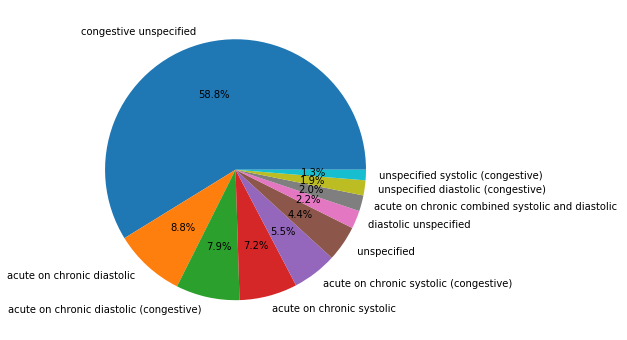

In [149]:
fig = plt.figure(figsize =(12, 6))
plt.pie(df_icd_summary['count'], labels = df_icd_summary['short_title'], autopct='%1.1f%%')
plt.savefig('icd_breakdown.png', bbox_inches='tight')
plt.show()


In [164]:
#df_f7.groupby(['short_title']).size().sort_values(ascending=True).nlargest(12).plot(kind="barh",title='')

In [165]:
#df_f7.groupby(['short_title']).size().nlargest(10).plot(kind="pie")

In [166]:
# TODO extract number of unique hadm
size_filters = [n1,n7,n7+19,n7,n7] # change numbers
n_step = 5 

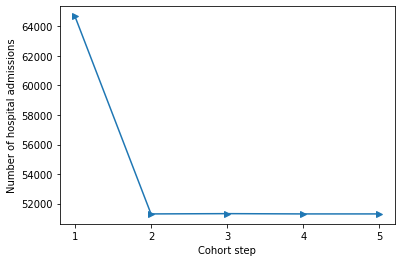

In [167]:
plt.plot(np.linspace(1,n_step,n_step), size_filters,marker=">")
plt.xticks(np.linspace(1,n_step,n_step))
plt.xlabel("Cohort step")
plt.ylabel("Number of hospital admissions")
plt.savefig('extraction_process.png', bbox_inches='tight')
plt.show()